# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [3]:
df = pd.read_excel('geo_comment.xlsx',index_col=0)

In [4]:
df.head(2)

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...


### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

In [5]:
X = np.array(df[['x','y']])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
inert = []

for i in range(1,30):
    knn_cluster = KMeans(n_clusters=i)
    clusters = knn_cluster.fit_predict(X_scaled)
    inert.append(knn_cluster.inertia_)

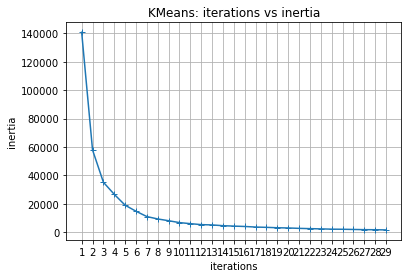

In [7]:
plt.plot(range(1,30), inert,'+-')
plt.xlabel('iterations')
plt.ylabel('inertia')
plt.title('KMeans: iterations vs inertia')
plt.xticks(range(1,30))
plt.grid()

На 5-6 Кластерах изменение разницы расстояний не заметно.  
Проверим 6 кластеров на GridSearch:

In [8]:
silhouette_score(X_scaled,labels=clusters,metric='euclidean',sample_size=30000)

0.7158098582799334

In [9]:
silhouette_score(X_scaled,labels=clusters,metric='euclidean',sample_size=30000)

0.7163127856684806

In [10]:
# изменяя размер выборки для подсчета можно существенно сократить время расчета, 
# при этом результат изменяется на сотые доли
silhouette_score(X_scaled,labels=clusters,metric='euclidean',sample_size=15000)

0.7179376483980765

Создадим функцию **Siluette score** которую отправим в GridSearchCV:

In [9]:
def sil_score(clf, X_array):
    cluster_array = clf.fit_predict(X_array)
    return silhouette_score(X_array,labels=cluster_array,metric='euclidean',sample_size=12000)

In [12]:
sil_score(knn_cluster,X_scaled)

0.7129458582615743

In [11]:
from sklearn.model_selection import GridSearchCV

In [14]:
params = {'n_clusters':list(range(2,9,1))  }
knn_grid = GridSearchCV(KMeans() , params, cv=5,
             scoring=sil_score, n_jobs=-1 )
knn_grid.fit(X_scaled)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': [2, 3, 4, 5, 6, 7, 8]},
             scoring=<function sil_score at 0x0000000004ED0F70>)

In [15]:
knn_grid.best_params_

{'n_clusters': 6}

In [16]:
final_clusters = knn_grid.best_estimator_.fit_predict(X_scaled)

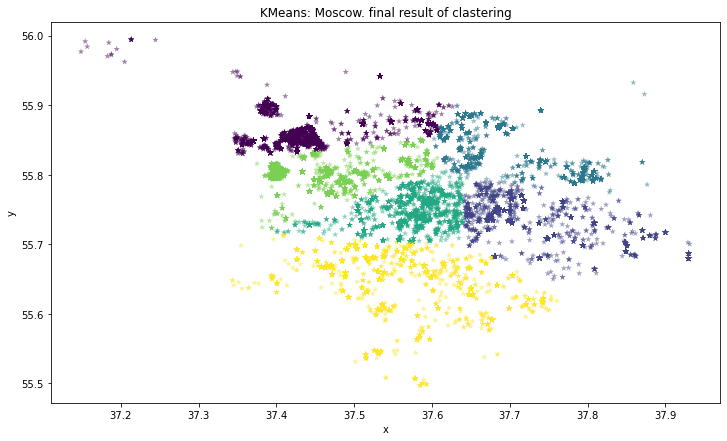

In [18]:
# Результат KMeans = Самый лучший показатель n_clusters=6
plt.figure(figsize=(12,7))
plt.scatter(X[:,0], X[:,1],c=final_clusters, alpha=.5,linewidths =.1, marker='*')
#center = knn_grid.best_estimator_.cluster_centers_
#plt.scatter(center[:,0], center[:,1], s=50, marker='+')
plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans: Moscow. final result of clastering');

Видно на разделение на 
- Север(с Химками), 
- район ВДНХ+Балашиха,
- район Фили, 
- Восток( м.Электрозаводская),
- Юг Москвы и
- Центр    

#### AffinityPropagation

In [19]:
affinity_scanner = AffinityPropagation()

In [20]:
X_scaled = np.array(X_scaled, dtype=np.float16)

In [ ]:
affinity_clusters = affinity_scanner.fit_predict(X_scaled)
silhouette_score(X_scaled,affinity_clusters,sample_size=12000 )

#### DBScan

In [22]:
DB_scanner = DBSCAN(eps=.1 ,n_jobs=-1)

In [23]:
DB_scan_clusters = DB_scanner.fit_predict(X_scaled)
silhouette_score(X_scaled,DB_scan_clusters,sample_size=12000 )

0.3875277270772423

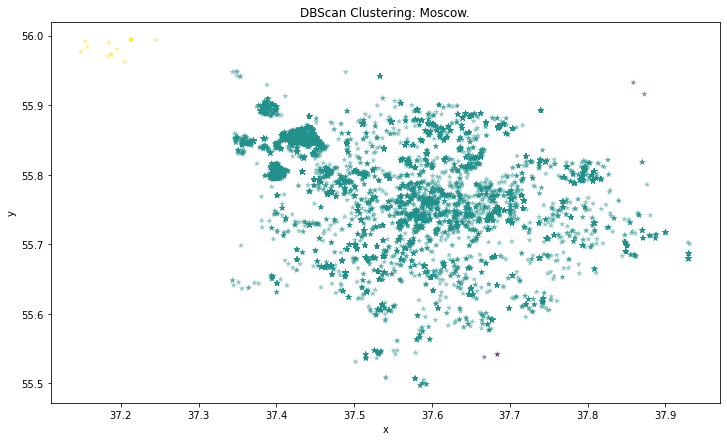

In [24]:
# Результат DBScan
plt.figure(figsize=(12,7))
plt.scatter(X[:,0], X[:,1],c=DB_scan_clusters, alpha=.5,linewidths =.1, marker='*')

plt.xlabel('x')
plt.ylabel('y')
plt.title('DBScan Clustering: Moscow.');

Плохое разделение от DBScan - видно он для этого не годится 

#### ДЗ№3. Аналогично исследовать скопления голосов за и против отдельно. Подобрать оптимальное число кластеров

In [30]:
df.head(2)

,x,y,comment_class,multiplier,comment,cluster
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...,3.441478
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...,3.441478


In [46]:
# Разобъем на выборки
positive_comment_X = np.array(df[df.comment_class==1][['x','y']])
negative_comment_X = np.array(df[df.comment_class==-1][['x','y']])

In [36]:
positive_comment_X_scaled = scaler.fit_transform(positive_comment_X)
negative_comment_X_scaled = scaler.fit_transform(negative_comment_X)

In [40]:
# негативных больше
positive_comment_X_scaled.shape, negative_comment_X_scaled.shape

((11830, 2), (58552, 2))

#### Разобъем по негативным

In [41]:
params = {'n_clusters':list(range(2,7,1))  }
knn_grid = GridSearchCV(KMeans() , params, cv=5,
             scoring=sil_score, n_jobs=-1 )
knn_grid.fit(negative_comment_X_scaled)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': [2, 3, 4, 5, 6]},
             scoring=<function sil_score at 0x0000000004ED0F70>)

In [42]:
knn_grid.best_params_

{'n_clusters': 6}

In [43]:
final_clusters_negative_comments = knn_grid.best_estimator_.fit_predict(negative_comment_X_scaled)

In [49]:
positive_comment_X_df = pd.DataFrame( df[df.comment_class==1])
negative_comment_X_df = pd.DataFrame( df[df.comment_class==-1])

In [50]:
negative_comment_X_df['cluster'] = final_clusters_negative_comments

In [51]:
negative_comment_X_df.groupby(by='cluster').multiplier.agg( ['sum','count','mean']) 

,sum,count,mean
cluster,,,
0,21299,7272,2.928905
1,15975,15251,1.047472
2,6774,6774,1.000000
3,20753,7606,2.728504
4,24898,18555,1.341849
5,5448,3094,1.760827


In [52]:
cluster_votes = dict(negative_comment_X_df.groupby(by='cluster').multiplier.mean()  )

In [53]:
negative_comment_X_df['cluster'] = negative_comment_X_df.cluster.map(cluster_votes)
negative_comment_size_array = np.array(negative_comment_X_df.cluster)

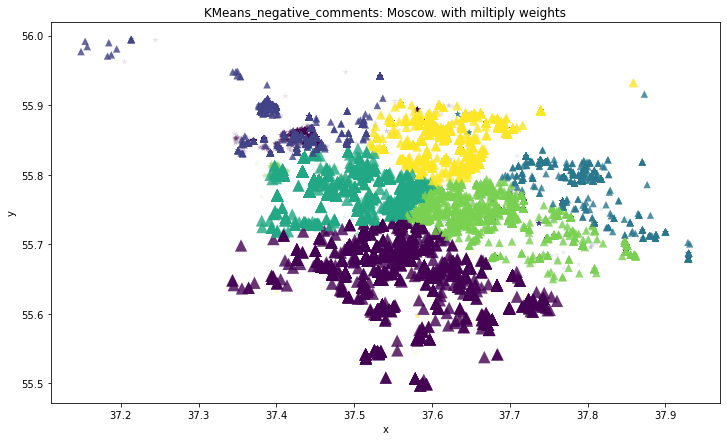

In [55]:
# Результат KMeans negative_comments = Самый лучший показатель n_clusters=6
plt.figure(figsize=(12,7))
plt.scatter(X[:,0], X[:,1],c=final_clusters, alpha=.1,linewidths =.1, marker='*')
plt.scatter(negative_comment_X[:,0], negative_comment_X[:,1],c=final_clusters_negative_comments,
            alpha=.8,linewidths =.1, marker='^',s=negative_comment_size_array*50)

plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans_negative_comments: Moscow. with miltiply weights');

Видно, что разделения совпали, разве что район "ВДНХ+Балашиха" уплыл на на Север, 
Чаще всего рамсят: 
- Юг Москвы 
- Восток( м.Электрозаводская)
- Центр
- "ВДНХ+Балашиха"

Только на Севере(с Химками) и Люберцах меньше всего обращений - видно у них все в порядке.

#### Разобъем по позитивным отзывам

In [57]:
params = {'n_clusters':list(range(2,8,1))  }
knn_grid = GridSearchCV(KMeans() , params, cv=5,
             scoring=sil_score, n_jobs=-1 )
knn_grid.fit(positive_comment_X_scaled)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': [2, 3, 4, 5, 6, 7]},
             scoring=<function sil_score at 0x0000000004ED0F70>)

In [58]:
knn_grid.best_params_

{'n_clusters': 7}

In [59]:
final_clusters_positive_comments = knn_grid.best_estimator_.fit_predict(positive_comment_X_scaled)

In [49]:
positive_comment_X_df = pd.DataFrame( df[df.comment_class==1])
negative_comment_X_df = pd.DataFrame( df[df.comment_class==-1])

In [60]:
positive_comment_X_df['cluster'] = final_clusters_positive_comments

In [61]:
positive_comment_X_df.groupby(by='cluster').multiplier.agg( ['sum','count','mean']) 

,sum,count,mean
cluster,,,
0,4831,3698,1.306382
1,1806,1806,1.000000
2,3093,3093,1.000000
3,1172,1078,1.087199
4,1234,1186,1.040472
5,703,703,1.000000
6,820,266,3.082707


In [62]:
cluster_votes = dict(positive_comment_X_df.groupby(by='cluster').multiplier.mean()  )

In [63]:
positive_comment_X_df['cluster'] = positive_comment_X_df.cluster.map(cluster_votes)
positive_comment_size_array = np.array(positive_comment_X_df.cluster)

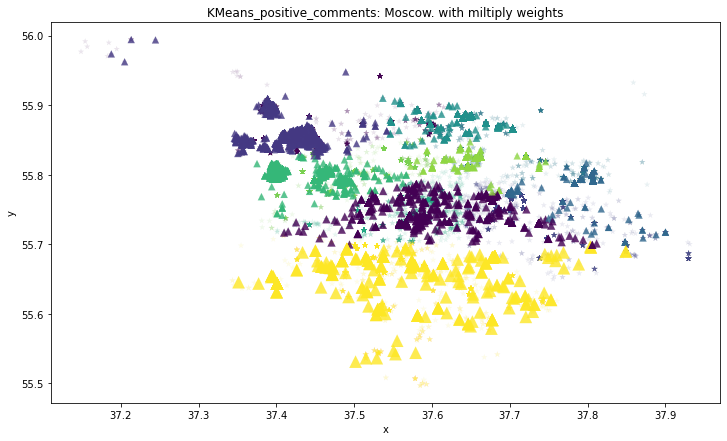

In [64]:
# Результат KMeans negative_comments = Самый лучший показатель n_clusters=6
plt.figure(figsize=(12,7))
plt.scatter(X[:,0], X[:,1],c=final_clusters, alpha=.1,linewidths =.1, marker='*')
plt.scatter(positive_comment_X[:,0], positive_comment_X[:,1],c=final_clusters_positive_comments,
            alpha=.8,linewidths =.1, marker='^',s=positive_comment_size_array*50)

plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans_positive_comments: Moscow. with miltiply weights');

Позитивных обращений больше у:
- Севере(с Химками) -> *как и предполагалось*
- Юг Москвы 
- Центр
- Фили

Только на ВДНХ и Люберцы меньше всего положительных обращений - видно район такой..

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [25]:
df['cluster'] = final_clusters

In [26]:
df.groupby(by='cluster').multiplier.agg( ['sum','count','mean']) 

,sum,count,mean
cluster,,,
0,18541,17697,1.047692
1,20667,20338,1.016177
2,10053,10034,1.001894
3,24875,7228,3.441478
4,13945,8664,1.609534
5,20725,6421,3.227690


In [27]:
cluster_votes = dict(df.groupby(by='cluster').multiplier.mean()  )

In [28]:
df['cluster'] = df.cluster.map(cluster_votes)
size_array = np.array(df.cluster)

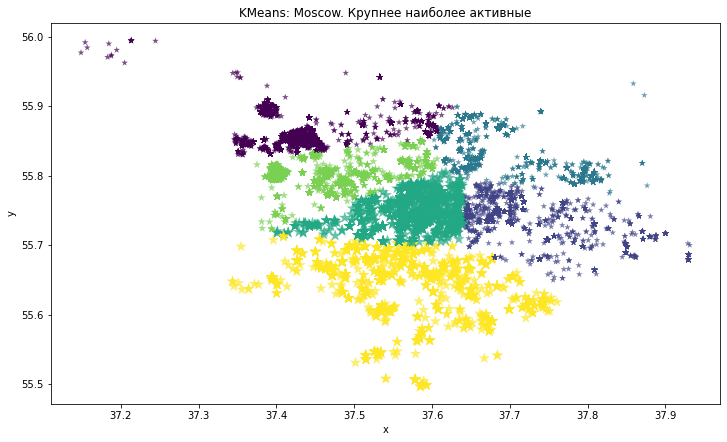

In [29]:
# Результат KMeans = Самый лучший показатель n_clusters=7, size = наиболее активным районам
plt.figure(figsize=(12,7))
plt.scatter(X[:,0], X[:,1],c=final_clusters, alpha=.7,linewidths =.1, marker='*',s=size_array*40)

plt.xlabel('x')
plt.ylabel('y')
plt.title('KMeans: Moscow. Крупнее наиболее активные');

#### ДЗ№5. Для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [4]:
import pymorphy2
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [3]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()

In [68]:
corpus = list(df.comment)

In [114]:
def get_lemmas(sentence):
    l = re.sub(r'[^А-яа-яёЁ]+',' ',sentence ).split()
    words = [i for i in l if (i not in ['вл','А','Б' ,'кв','На','й','пер','м'  ] ) and ( i not in stop_words)]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return lemmas

In [ ]:
# Разобъем на предложения:
lemmas_result_array = []

for comment in corpus:
    sentences = sent_tokenize(comment)
    
    lemmas = []
    for sentence in sentences:
        lemmas += get_lemmas(sentence)

    lemmas_result_array.append(lemmas)

In [4]:
lemmas_result_list = []

for i in range( len(lemmas_result_array) ):
    lemmas_result_list.append(' '.join( lemmas_result_array[i] ) )

#### Есть два варианта: 
- option A: Разбить на кластера и найти топ ключевых слов в каждом кластере
- option B: Посчитать самое повторяемое слово во всех комментариях 

#### Option A. Разбить на кластера и найти топ ключевых слов в каждом кластере

In [9]:
lemmas_X = tf_idf_vect.fit_transform(lemmas_result_list)

In [12]:
# чтобы не забивать оперативу уменьшим тип переменной np.float16
lemmas_X_dense = np.array(lemmas_X.todense(),dtype=np.float16)

In [ ]:
# Это найдет самую лучшую разбивку на кластеры
params = {'n_clusters':list(range(2,8,1))  }
knn_grid = GridSearchCV(KMeans() , params, cv=5,
             scoring=sil_score, n_jobs=-1 )

knn_grid.fit(lemmas_X.todense())

print(knn_grid.best_params_)

comment_clusters = knn_grid.best_estimator_.fit_predict(lemmas_X.todense())

In [11]:
columns = tf_idf_vect.get_feature_names()

In [ ]:
# Найдем разбивку на 7 кластеров:
comment_clusters = KMeans(n_clusters=7).fit_predict(lemmas_X_dense)

#### В итоге
моей оперативки 8Гб и core i7 не хватило чтобы потянуть разбивку на кластеры, поэтому выужден перейти к плану Б. 
Также прикладываю код, для тех у кого получится разбить на кластеры

In [ ]:
words_df = pd.DataFrame(data= lemmas_X_dense, columns=columns)

In [ ]:
words_df['cluster'] = comment_clusters

In [ ]:
clusters = pd.DataFrame(df.groupby(by='cluster')[columns].mean()).T

In [ ]:
claster=[]

for i in range( len( set(comment_clusters) ) ):
    claster.append( list(clusters[i].sort_values(ascending=False).head().index) )
claster

In [ ]:
for i,data in enumerate(claster):
    print(f'Кластер {i}, топ 5 ключевых слов в комментариях: {data}')

#### option B. Посчитать самое повторяемое слово во всех комментариях 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vectorizer = CountVectorizer()

In [8]:
X = vectorizer.fit_transform(lemmas_result_list)

In [12]:
df = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())

In [14]:
pd.Series(df[df.columns].sum()).sort_values(ascending=False).head()

проект       511542
москва       496375
участок      421753
застройка    411928
зона         357739
dtype: int64

Топ 5 самых цитируемых слов в комментариях.  
Было бы здорово разбить по кластерам KMeans, но для этого оператвки должно быть больше 8Гб.  
Если есть предложения как можно было бы облегчить код, поделитесь.  